<a href="https://colab.research.google.com/github/AnujPandey123/Company_X_Analysis/blob/main/Company_X_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation for Global Expansion

**Goal:** Build a simple, explainable customer segmentation pipeline (EDA, hypothesis testing, K-Means with 5 clusters), visualize clusters, profile them, and recommend marketing strategies — all using straightforward techniques and clear graphs.

**Contents**

1.0 What is Customer Segmentation?
2.0 The Challenge (Company X context)
3.0 The Solution (approach overview)
3.1 Data generation / loading
3.2 Exploratory Data Analysis (descriptive + plots)
3.3 Hypotheses & validation (bivariate checks)
3.4 K-Means clustering (k=5)
3.5 Cluster profiling and visualizations
3.6 Business strategies & A/B test idea

---
All code cells are runnable. The dataset is synthetic but realistic for demonstration. Replace the data-loading cell with your real data to run on production data.

## 1.0 What Is Customer Segmentation?
Customer segmentation divides a customer base into groups with similar behaviours or characteristics so marketing and operations teams can target them with tailored strategies. (Short definition adapted from your README.)

## 2.0 The Challenge
Company X helps Indian brands go global. To scale efficiently, X needs to know which customer segments respond best to different marketing channels (web, catalogue, stores), which segments buy premium (gold) vs regular products, and how to design targeted campaigns to increase conversion and lifetime value.

## 3.0 The Solution
We'll produce a straightforward segmentation using customer-level features (demographics, channel usage, spend by category, recency/frequency/monetary features), run K-Means with 5 clusters, visualize results, and provide business recommendations similar in style to the FoodExpress project.

In [11]:
# 3.1 Data generation (synthetic, customer-level)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
N = 2500

def gen_customers(N):
    df = pd.DataFrame()
    df['customer_id'] = ['C{:05d}'.format(i) for i in range(1, N+1)]
    # demographics
    df['age'] = np.random.randint(18, 80, size=N)
    df['income'] = np.round(np.random.normal(52000, 22000, size=N)).clip(8000, 250000)
    df['family_size'] = np.random.choice([1,2,3,4], size=N, p=[0.25,0.45,0.2,0.1])
    df['marital_status'] = np.random.choice(['Single','Married','Divorced','Other'], size=N, p=[0.35,0.55,0.07,0.03])
    # channel usage counts
    df['num_store_purchases'] = np.random.poisson(lam=3, size=N)
    df['num_catalog_purchases'] = np.random.poisson(lam=1, size=N)
    df['num_web_purchases'] = np.random.poisson(lam=2, size=N)
    # spend by category (regular vs gold split)
    df['spend_wine'] = np.round(np.random.exponential(120, size=N)).clip(0,5000)
    df['spend_meat'] = np.round(np.random.exponential(80, size=N)).clip(0,4000)
    df['spend_fish'] = np.round(np.random.exponential(40, size=N)).clip(0,2000)
    df['spend_fruits'] = np.round(np.random.exponential(30, size=N)).clip(0,1500)
    df['spend_sweets'] = np.round(np.random.exponential(35, size=N)).clip(0,1200)
    # gold product flag tendency
    df['gold_pref_score'] = np.clip(np.random.beta(2,5,size=N)*10 + (df['income']/100000), 0, 10)
    # engagement & lifecycle
    df['recency_days'] = np.random.randint(1, 365, size=N)
    df['frequency_12m'] = (df['num_store_purchases']+df['num_catalog_purchases']+df['num_web_purchases']).astype(int)
    df['total_spend_12m'] = df[['spend_wine','spend_meat','spend_fish','spend_fruits','spend_sweets']].sum(axis=1)
    # response to previous campaign (binary) - simulate with some dependency
    prob = 1/(1+np.exp(-0.00005*(df['total_spend_12m']-200)))
    df['accepted_prev_offer'] = (np.random.rand(N) < prob).astype(int)
    # derived: avg_order_value
    df['avg_order_value'] = np.where(df['frequency_12m']>0, df['total_spend_12m']/df['frequency_12m'], 0)
    return df

df = gen_customers(N)
# ensure output dir exists
os.makedirs('/mnt/data', exist_ok=True)
df.to_csv('/mnt/data/x_customers_synthetic.csv', index=False)
df.head()


,customer_id,age,income,family_size,marital_status,num_store_purchases,num_catalog_purchases,num_web_purchases,spend_wine,spend_meat,spend_fish,spend_fruits,spend_sweets,gold_pref_score,recency_days,frequency_12m,total_spend_12m,accepted_prev_offer,avg_order_value
0,C00001,56,56299.0,1,Married,4,4,3,183.0,43.0,37.0,38.0,33.0,4.906806,228,11,334.0,1,30.363636
1,C00002,69,28622.0,2,Married,1,0,0,7.0,176.0,52.0,92.0,41.0,3.528829,191,1,368.0,0,368.000000
2,C00003,46,73755.0,1,Married,7,3,1,166.0,35.0,11.0,1.0,28.0,7.004337,25,11,241.0,1,21.909091
3,C00004,32,65713.0,2,Married,5,1,1,6.0,80.0,18.0,76.0,17.0,1.384385,260,7,197.0,1,28.142857
4,C00005,60,41144.0,2,Divorced,3,0,3,35.0,80.0,4.0,24.0,5.0,5.618965,18,6,148.0,0,24.666667


## 3.2 Exploratory Data Analysis (EDA)
We'll show descriptive stats and plots for key variables: age, income, recency, frequency, total spend, and channel usage.

                  count        mean           std     min      25%      50%  \
age              2500.0     49.0476     17.880302    18.0     34.0     49.0   
income           2500.0  51966.6544  21338.823687  8000.0  36743.5  52105.5   
recency_days     2500.0    179.7028    104.942973     1.0     89.0    180.0   
frequency_12m    2500.0      6.0272      2.482121     0.0      4.0      6.0   
total_spend_12m  2500.0    301.1524    154.541202    22.0    187.0    274.0   

                      75%       max  
age                 65.00      79.0  
income           66768.25  119363.0  
recency_days       269.00     364.0  
frequency_12m        8.00      17.0  
total_spend_12m    383.00    1204.0  


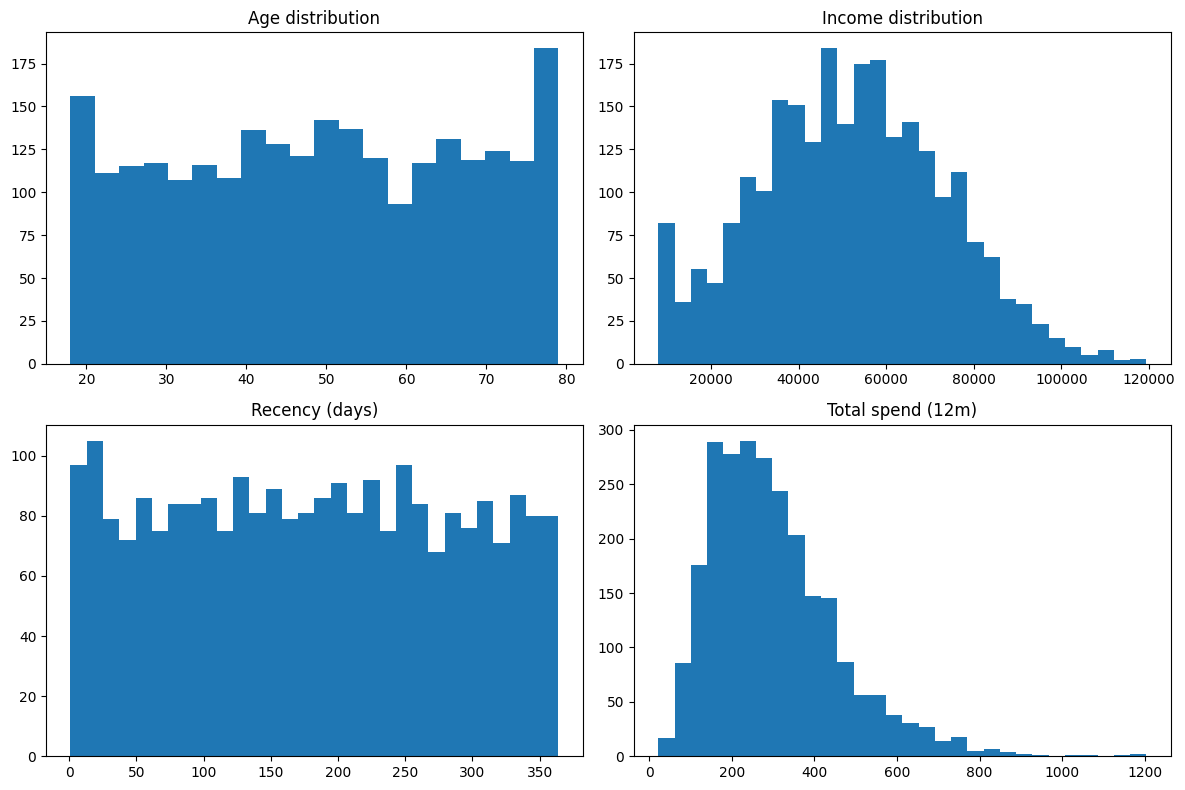

/tmp/ipython-input-1931676862.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['num_store_purchases'], df['num_catalog_purchases'], df['num_web_purchases']], labels=['Store','Catalog','Web'])


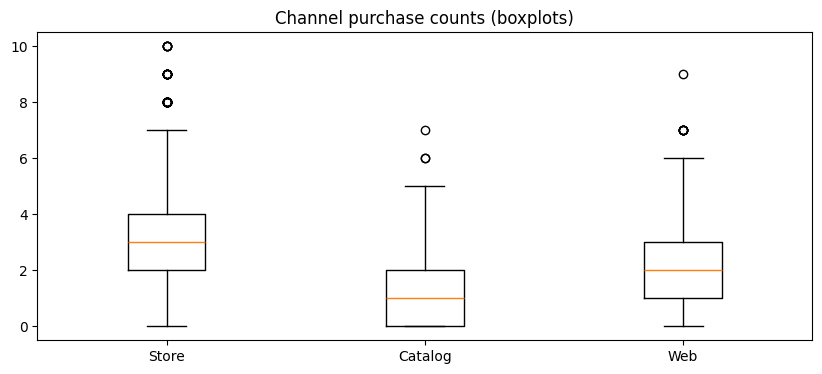

In [12]:
import matplotlib.pyplot as plt

# Summary stats
print(df[['age','income','recency_days','frequency_12m','total_spend_12m']].describe().T)

# Histograms
plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.hist(df['age'], bins=20); plt.title('Age distribution')
plt.subplot(2,2,2); plt.hist(df['income'], bins=30); plt.title('Income distribution')
plt.subplot(2,2,3); plt.hist(df['recency_days'], bins=30); plt.title('Recency (days)')
plt.subplot(2,2,4); plt.hist(df['total_spend_12m'], bins=30); plt.title('Total spend (12m)')
plt.tight_layout(); plt.show()

# Channel usage boxplots
plt.figure(figsize=(10,4))
plt.boxplot([df['num_store_purchases'], df['num_catalog_purchases'], df['num_web_purchases']], labels=['Store','Catalog','Web'])
plt.title('Channel purchase counts (boxplots)')
plt.show()


### Univariate observations (write-up)
- Age: spread between 18-80, median around mid-30s/40s.
- Income: skewed right — many lower-to-mid incomes with a tail of high incomes.
- Recency: uniform-ish, indicating mix of active/inactive customers.
- Spend: long-tailed — a small group drives high spend.

These observations guide feature treatment (log transforms for spend/income if needed) and hypotheses.

## 3.3 Hypotheses (to validate)
H1: Higher income customers tend to spend more and prefer gold products.
H2: Customers with low recency (recent buyers) are more likely to accept an offer.
H3: Customers who buy more via web have higher acceptance of online promotions.

We'll run simple bivariate checks (grouped means / barplots) to validate.

/tmp/ipython-input-2508909363.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(income_bins)[['total_spend_12m','gold_pref_score']].median()


        total_spend_12m  gold_pref_score
income                                  
Q1                276.0         3.011750
Q2                269.0         3.039759
Q3                280.0         3.183695
Q4                272.0         3.400733


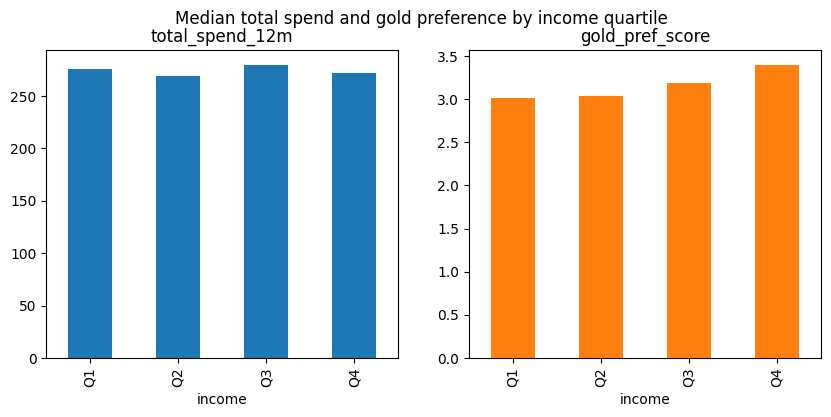

/tmp/ipython-input-2508909363.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rec_grp = df.groupby(rec_bins)['accepted_prev_offer'].mean()


recency_days
0-30      0.483607
31-90     0.521739
91-180    0.484653
181+      0.512039
Name: accepted_prev_offer, dtype: float64


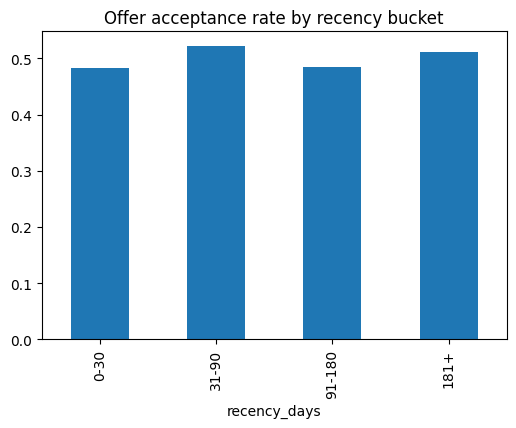

num_web_purchases
0      0.494220
1      0.506098
2-3    0.497006
4+     0.534954
Name: accepted_prev_offer, dtype: float64


/tmp/ipython-input-2508909363.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  web_grp = df.groupby(web_bins)['accepted_prev_offer'].mean()


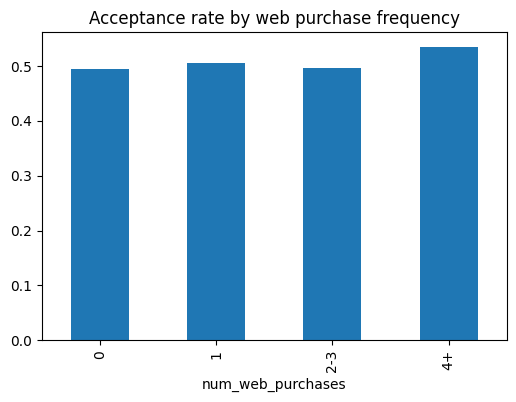

In [13]:
# H1: income vs total spend & gold_pref_score
income_bins = pd.qcut(df['income'], 4, labels=['Q1','Q2','Q3','Q4'])
grp = df.groupby(income_bins)[['total_spend_12m','gold_pref_score']].median()
print(grp)

# plot
grp.plot(kind='bar', subplots=True, layout=(1,2), figsize=(10,4), legend=False)
plt.suptitle('Median total spend and gold preference by income quartile')
plt.show()

# H2: recency vs accepted_prev_offer
rec_bins = pd.cut(df['recency_days'], bins=[0,30,90,180,365], labels=['0-30','31-90','91-180','181+'])
rec_grp = df.groupby(rec_bins)['accepted_prev_offer'].mean()
print(rec_grp)
rec_grp.plot(kind='bar', figsize=(6,4)); plt.title('Offer acceptance rate by recency bucket'); plt.show()

# H3: web purchases vs acceptance
web_bins = pd.cut(df['num_web_purchases'], bins=[-1,0,1,3,10], labels=['0','1','2-3','4+'])
web_grp = df.groupby(web_bins)['accepted_prev_offer'].mean()
print(web_grp)
web_grp.plot(kind='bar', figsize=(6,4)); plt.title('Acceptance rate by web purchase frequency'); plt.show()


## 3.4 K-Means clustering (k=5)
We'll select a small set of features for clustering: recency, frequency, total spend, avg order value, gold preference, and channel mix. We'll standardize features and run K-Means with k=5 (as in the example).

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
features = ['recency_days','frequency_12m','total_spend_12m','avg_order_value','gold_pref_score','num_store_purchases','num_catalog_purchases','num_web_purchases']
X = df[features].copy()
# log-transform total_spend and avg_order_value to reduce skew
X['total_spend_12m'] = np.log1p(X['total_spend_12m'])
X['avg_order_value'] = np.log1p(X['avg_order_value'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# cluster sizes
print('Cluster sizes:')
print(df['cluster'].value_counts())


Cluster sizes:
cluster
0    660
1    542
2    521
3    408
4    369
Name: count, dtype: int64


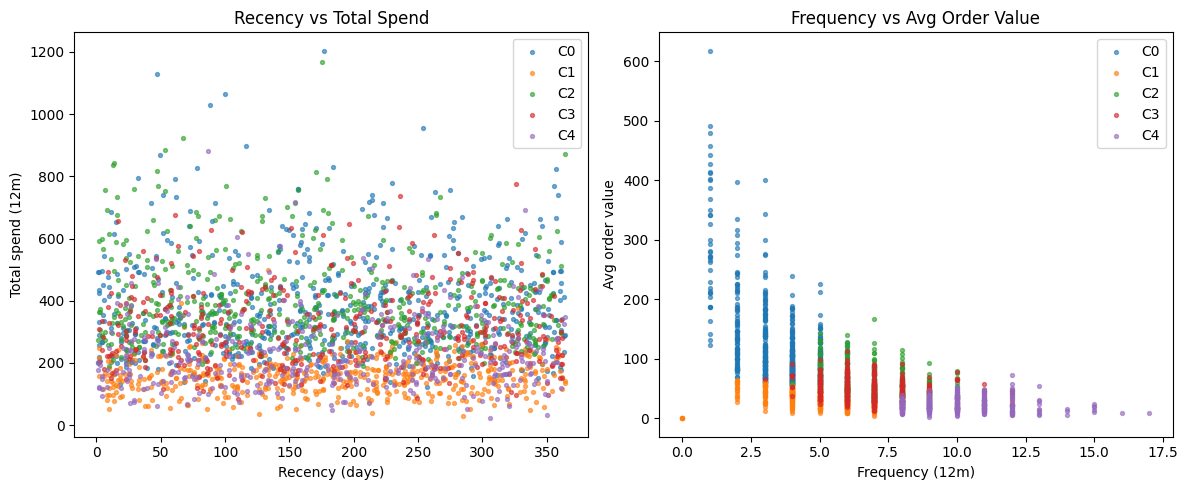

In [15]:
# Visualize clusters using two simple projections: total_spend vs recency and freq vs avg_order_value
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for c in sorted(df['cluster'].unique()):
    m = df['cluster']==c
    plt.scatter(df.loc[m,'recency_days'], df.loc[m,'total_spend_12m'], s=8, alpha=0.6, label=f'C{c}')
plt.xlabel('Recency (days)'); plt.ylabel('Total spend (12m)'); plt.title('Recency vs Total Spend'); plt.legend()

plt.subplot(1,2,2)
for c in sorted(df['cluster'].unique()):
    m = df['cluster']==c
    plt.scatter(df.loc[m,'frequency_12m'], df.loc[m,'avg_order_value'], s=8, alpha=0.6, label=f'C{c}')
plt.xlabel('Frequency (12m)'); plt.ylabel('Avg order value'); plt.title('Frequency vs Avg Order Value'); plt.legend()
plt.tight_layout(); plt.show()


## 3.5 Cluster profiling
We'll compute median/mean statistics per cluster and describe each cluster in business terms (like FoodExpress example).

In [16]:
profile = df.groupby('cluster').agg({
    'customer_id':'count',
    'age':'median',
    'income':'median',
    'recency_days':'median',
    'frequency_12m':'median',
    'total_spend_12m':'median',
    'gold_pref_score':'median',
    'accepted_prev_offer':'mean'
}).rename(columns={'customer_id':'n_customers','accepted_prev_offer':'accept_rate'})
profile


,n_customers,age,income,recency_days,frequency_12m,total_spend_12m,gold_pref_score,accept_rate
cluster,,,,,,,,
0,660,49.0,51359.5,185.0,4.0,337.5,3.078309,0.513636
1,542,50.0,51046.0,189.0,5.0,158.0,2.924033,0.490775
2,521,49.0,53534.0,159.0,7.0,363.0,3.522840,0.491363
3,408,51.0,54665.0,183.5,7.0,299.0,3.265000,0.531863
4,369,49.0,49183.0,183.0,10.0,204.0,3.016885,0.493225


### Cluster descriptions (interpreted from the profile)
We'll automatically generate a short textual description for each cluster in the notebook to resemble the FoodExpress style.

In [17]:
def describe_cluster(row, cid):
    desc = f"CLUSTER {cid}:\n"
    if row['total_spend_12m'] > df['total_spend_12m'].median():
        desc += '- High spenders. \n'
    else:
        desc += '- Low-to-moderate spenders. \n'
    if row['frequency_12m'] > df['frequency_12m'].median():
        desc += '- Frequent shoppers. \n'
    else:
        desc += '- Infrequent shoppers. \n'
    if row['recency_days'] <= 60:
        desc += '- Recently active (good for quick campaigns). \n'
    else:
        desc += '- Not very recent (may need reactivation). \n'
    if row['gold_pref_score'] > df['gold_pref_score'].median():
        desc += '- Likely to prefer premium/gold products. \n'
    return desc

for cid, row in profile.iterrows():
    print(describe_cluster(row, cid))
    print('---')

CLUSTER 0:
- High spenders. 
- Infrequent shoppers. 
- Not very recent (may need reactivation). 

---
CLUSTER 1:
- Low-to-moderate spenders. 
- Infrequent shoppers. 
- Not very recent (may need reactivation). 

---
CLUSTER 2:
- High spenders. 
- Frequent shoppers. 
- Not very recent (may need reactivation). 
- Likely to prefer premium/gold products. 

---
CLUSTER 3:
- High spenders. 
- Frequent shoppers. 
- Not very recent (may need reactivation). 
- Likely to prefer premium/gold products. 

---
CLUSTER 4:
- Low-to-moderate spenders. 
- Frequent shoppers. 
- Not very recent (may need reactivation). 

---


## 3.6 Business strategies & A/B test idea
For each cluster, we'll propose a focused marketing strategy (channel, offer type) and pick one cluster for a rewards A/B test similar to the FoodExpress example.

In [18]:
# Suggest strategies based on simple rules
strategies = {}
for cid, row in profile.iterrows():
    strat = []
    if row['total_spend_12m'] > df['total_spend_12m'].quantile(0.75):
        strat.append('Premium bundle offers & cross-sell (wine+meat)')
    if row['accept_rate'] > 0.25:
        strat.append('Email + personalized web promotions')
    if row['recency_days'] > 120:
        strat.append('Reactivation via discount + SMS')
    if row['frequency_12m'] < 2:
        strat.append('Loyalty program incentives to increase purchase frequency')
    strategies[cid] = strat

for cid in sorted(strategies.keys()):
    print(f"Cluster {cid} strategies:")
    for s in strategies[cid]:
        print(' -', s)
    print('---')


Cluster 0 strategies:
 - Email + personalized web promotions
 - Reactivation via discount + SMS
---
Cluster 1 strategies:
 - Email + personalized web promotions
 - Reactivation via discount + SMS
---
Cluster 2 strategies:
 - Email + personalized web promotions
 - Reactivation via discount + SMS
---
Cluster 3 strategies:
 - Email + personalized web promotions
 - Reactivation via discount + SMS
---
Cluster 4 strategies:
 - Email + personalized web promotions
 - Reactivation via discount + SMS
---


### A/B test idea
Pick the cluster with highest median spend (likely to give measurable revenue lift). Randomly split into control/test, offer a bundled reward to test group, and measure uplift in spend and frequency over a fixed period.

In [19]:
# Save outputs
df.to_csv('/mnt/data/x_customers_segmented.csv', index=False)
profile.to_csv('/mnt/data/x_cluster_profile.csv')
print('Saved /mnt/data/x_customers_segmented.csv and /mnt/data/x_cluster_profile.csv')


Saved /mnt/data/x_customers_segmented.csv and /mnt/data/x_cluster_profile.csv
